<a href="https://colab.research.google.com/github/Gyeong-Hyeon/AI_Project/blob/main/Section4/Facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introduction

#2. Materials & Method

##2-1. Dataset

###1) Downloading



*  [Kaggle Facial Expression Recognition(FER)Challenge](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge)

*  [Google facial expression comparison dataset](https://research.google/tools/datasets/google-facial-expression/)

*  [CK+48 5 emotions](https://www.kaggle.com/gauravsharma99/ck48-5-emotions)

*  [FER13 Cleaned Dataset](https://www.kaggle.com/gauravsharma99/fer13-cleaned-dataset?select=Neutral)

Only the first dataset was used for this project due to time & memory limit 😢





In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
ls -1ha kaggle.json

In [ ]:
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

In [ ]:
!unzip facial-expression-recognitionferchallenge.zip

Importing the required packages for this project

In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install h5py

In [3]:
import numpy as np
import pandas as pd
import math
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, Activation, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from keras_vggface.vggface import VGGFace
from keras.optimizers import Adam

###2) Preprocessing

Check the datatset

In [4]:
df = pd.read_csv('./fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

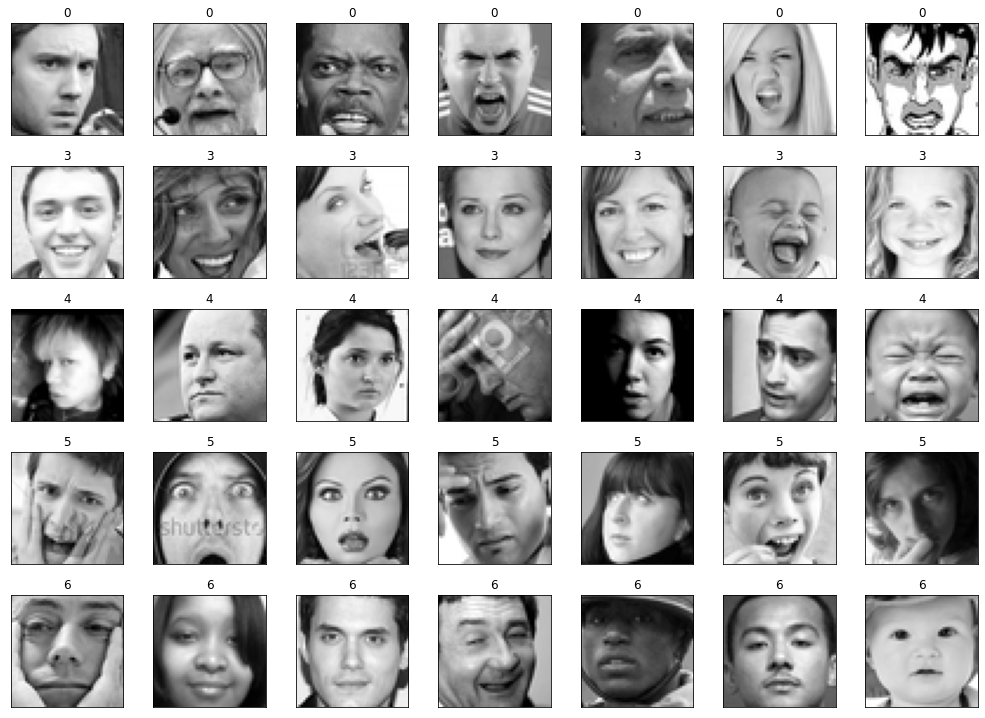

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        plt.tight_layout()

 check y labels

In [12]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

Y labels can be interpreted as below:
*   0 & 1: Angry/ Annoyed
*   3: Happy
*   4: Sad
*   2 & 5: Surprised
*   6: neutral --> change to label 1



In [5]:
data = df.copy() #just in case... make a copy of original data
df.emotion = df.emotion.replace(1,0) #combine label 1&0
df.emotion = df.emotion.replace(5,2) #combine label 2&5
df.emotion = df.emotion.replace(6,1) #change label 6 to 1
df.emotion.unique()

array([0, 2, 4, 1, 3])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


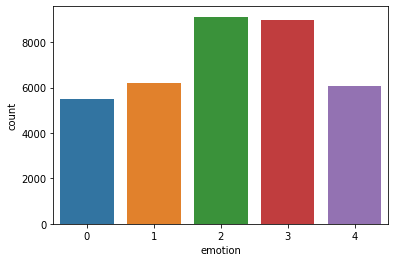

In [15]:
sns.countplot(df.emotion);

In [6]:
label = {0:'angry🤬', 1: 'neutral😐', 2:'surprised😱', 3:'happy🥳', 4: 'sad😥'}

In [7]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))/255
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

```
#Run this cell if you want to see how np.concatenate and np.stack is different!

print(df.pixels)
array1 = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
array2 = np.concatenate(array1, axis=0)
print(array1)
print(array2)
print(img_array)
```



> 여기서 stack과 concatenate 함수의 차이에 대해 짚고 넘어가겠습니다. stack 함수는 concatenate에 reshape 과정이 추가 된 함수입니다. 따라서 A,B 두 array를 concat을 하면 단순히 지정한 축을 기준으로 두 배열을 붙이게 됩니다. 따라서 차원이 증가하지 않습니다. 하지만 stack 함수는 중간에 지정한 축의 shape를 한 차원으로 지정해 주는 과정을 거침으로써, 배열을 붙이는 것이 아니라 차원을 늘려서 나란히 배열하는 기능을 수행합니다.

따라서 위의 데이터에 concatenate함수를 사용하게 되면, (1722576, 48, 1)의 img_array를 얻게 됩니다 (35887 * 48 = 1,722,576). 우리는 여기서 48x48 이미지 35,887장을 나란히 쌓아야 하므로 concatenate함수가 아닌 stack 함수를 사용하는 것입니다.

---





Change labels to one-hot vectors

In [8]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 5)

Keep which label is mapped to each vector

In [9]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


Split train/test dataset

In [10]:
X_train, X, y_train, y = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.3, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((25120, 48, 48, 1),
 (5383, 48, 48, 1),
 (5384, 48, 48, 1),
 (25120, 5),
 (5383, 5),
 (5384, 5))

###3) Dataset for Bidrectional LSTM

❓ Why LSTM need different dimension of dataset

In [112]:
img_array_lstm = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(1, 48, 48, 1).astype('float32'))/255
img_array_lstm = np.stack(img_array_lstm, axis=0)
img_array_lstm.shape

(35887, 1, 48, 48, 1)

In [114]:
X_train_lstm, X, y_train_lstm, y = train_test_split(img_array_lstm, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.3, random_state=10)
X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.5, random_state=10)
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape, y_train_lstm.shape, y_val_lstm.shape, y_test_lstm.shape

((25120, 1, 48, 48, 1),
 (5383, 1, 48, 48, 1),
 (5384, 1, 48, 48, 1),
 (25120, 5),
 (5383, 5),
 (5384, 5))

###4) Dataset for transfer learning

In [ ]:
def preprocess_input(x):
    x -= 128.8006 # np.mean(train_dataset)
    return x

def get_data(dataset):
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)
    pixels = data['pixels'].tolist()
    images = np.empty((len(data), img_height, img_width, 3))
    i = 0

    for pixel_sequence in pixels:
        single_image = [float(pixel) for pixel in pixel_sequence.split(' ')]  # Extraction of each single
        single_image = np.asarray(single_image).reshape(48, 48) # Dimension: 48x48
        single_image = resize(single_image, (img_height, img_width), order = 3, mode = 'constant') # Dimension: 139x139x3 (Bicubic)
        ret = np.empty((img_height, img_width, 3))  
        ret[:, :, 0] = single_image
        ret[:, :, 1] = single_image
        ret[:, :, 2] = single_image
        images[i, :, :, :] = ret
        i += 1
    
    images = preprocess_input(images)
    labels = to_categorical(data['emotion'])

    return images, labels    

# Data preparation
train_data_x, train_data_y  = get_data(train_dataset)
val_data  = get_data(eval_dataset)

###5) Issues

This dataset has following problems:

*   **Class imbalance**

  There is an imbalance between classes. It became better than the original dataset after combining class 1 & 0 and 2& 5, and  we can mitigate it more by data augmentation.

*   **Intra-class variation**

 Some datas are real photos but some are cartoons. We can solve this problem by avoiding over-fitting.


*   **Eye glasses**

 Some peoples are wearing glasses even eyes are really important factor to detect emotion. 


##2-2. Modeling

###1) SVM

https://github.com/Kumaava/Facial_Emotion_classifier/blob/master/image_import.ipynb

In [ ]:
## Loading and curating the data
digits = datasets.load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

## Computing t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))
plt.show()

In [ ]:
c_vals=[1, 5, 10, 30, 100, 300, 1000]
gamma_vals=[1, 0.1, 0.01, 0.03, 0.0001, 0.00001, 'auto'])

param_grid = [
  {'C': c_vals, 'gamma': gamma_vals},
  ]

svc = GridSearchCV(SVC(kernel='rbf',decision_function_shape='ovr'), param_grid, n_jobs=-1, cv=10, scoring='accuracy')
print(svc.best_estimator_)

svc.fit(X_train, Y_train)
print('train score (%s):'%scoring, svc.score(X_train, Y_train)
val_score = svc.score(X_val, Y_val)
print('test score (%s):'%scoring, test_score)

###2) DCNN

I used 'Elu' as an activation fuction for hidden layers. What different from Leaky Relu is Elu has non-linear shape of graph under 0.

**Pros**

*   ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.
*   ELU is a strong alternative to ReLU.

*   Unlike to ReLU, ELU can produce negative outputs.

**Cons**

*   For x > 0, it can blow up the activation with the output range of [0, inf].

<p align="center">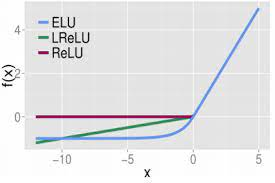</p>

In [69]:
def build_dcnn(input_shape, show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            5,
            activation='softmax',
            name='out_layer'
        )
    )

    if show_arch:
        net.summary()
    return net

I used two call backs to avoid overfitting - early_stopping and ReduceLROnPlateau.
ReduceLROnPlateau monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced sothat we can escape a local minimum.

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [21]:
batch_size = 32
optimizer = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
 
model = build_dcnn((48,48,1))
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=200,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


785/785 [==============================] - 56s 67ms/step - loss: 2.0218 - accuracy: 0.2472 - val_loss: 1.4432 - val_accuracy: 0.4033
Epoch 2/200
785/785 [==============================] - 52s 66ms/step - loss: 1.4905 - accuracy: 0.3658 - val_loss: 1.4038 - val_accuracy: 0.4284
Epoch 3/200
785/785 [==============================] - 52s 66ms/step - loss: 1.3743 - accuracy: 0.4261 - val_loss: 1.3102 - val_accuracy: 0.4980
Epoch 4/200
785/785 [==============================] - 52s 66ms/step - loss: 1.2679 - accuracy: 0.4873 - val_loss: 1.1223 - val_accuracy: 0.5506
Epoch 5/200
785/785 [==============================] - 52s 66ms/step - loss: 1.2142 - accuracy: 0.5090 - val_loss: 1.0847 - val_accuracy: 0.5720
Epoch 6/200
785/785 [==============================] - 52s 66ms/step - loss: 1.1490 - accuracy: 0.5414 - val_loss: 1.0547 - val_accuracy: 0.5790
Epoch 7/200
785/785 [==============================] - 52s 66ms/step - loss: 1.1236 - accuracy: 0.5490 - val_loss: 1.0762 - val_accuracy: 0.57

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

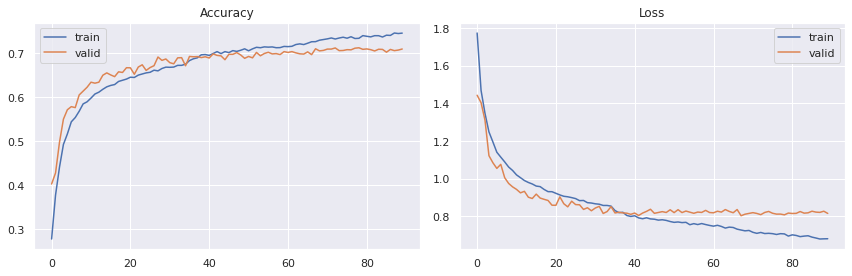

In [22]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong validation predictions: 1558


              precision    recall  f1-score   support

           0       0.63      0.70      0.67       825
           1       0.60      0.72      0.65       930
           2       0.79      0.66      0.72      1369
           3       0.87      0.86      0.86      1349
           4       0.60      0.56      0.58       911

    accuracy                           0.71      5384
   macro avg       0.70      0.70      0.70      5384
weighted avg       0.72      0.71      0.71      5384



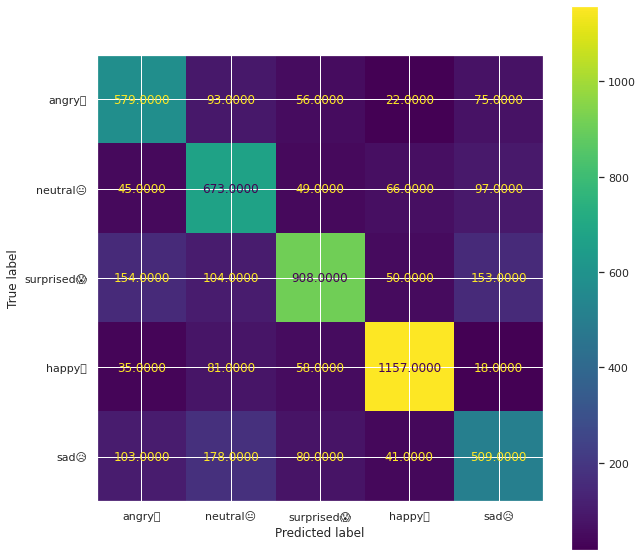

In [55]:
from sklearn.metrics import classification_report

yhat_valid = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

###3) DCNN + LSTM

It is known that the generation of facial expression involves movements of several organs such as eyebrows, eyes and lips, which are also described as action units (AUs). More AUs will be involved as the facial expression becomes more complicated. In this letter, some researchers investigated the facial
expression recognition problem by leveraging the correlations between AUs and learning the spatial dependency information among different image regions through long short-term memory (LSTM) and found the accuracy was better than DNN models.





*   keras.TimeDistributed: This function is used for many-to-many LSTM models. It allows to apply a layer to every temporal slice of an input. Cost(error) is calcualated at each step and the cost propagates to the lower steps as if each step is connected with FC.

(For more explanation in Korean - please click 👉 [here](https://m.blog.naver.com/chunjein/221589624838))
*   List item





In [76]:
def memory_model(input_shape, num_class=5, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False) #The model definded above (show_arch=False: to do not print model.summary of DCNN model)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

set call backs again

In [63]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [115]:
INPUT_SHAPE = (1, 48, 48, 1)
batch_size = 32
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 5)              2395333   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 256)            137216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None,

In [119]:
history = model.fit(
    x=X_train_lstm,
    y=y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    batch_size=batch_size,
    epochs=200,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/200
785/785 [==============================] - 92s 105ms/step - loss: 1.6262 - accuracy: 0.2675 - val_loss: 1.4023 - val_accuracy: 0.4234
Epoch 2/200
785/785 [==============================] - 80s 102ms/step - loss: 1.4146 - accuracy: 0.4132 - val_loss: 1.2852 - val_accuracy: 0.4750
Epoch 3/200
785/785 [==============================] - 80s 102ms/step - loss: 1.3040 - accuracy: 0.4703 - val_loss: 1.1820 - val_accuracy: 0.5293
Epoch 4/200
785/785 [==============================] - 80s 102ms/step - loss: 1.2325 - accuracy: 0.5142 - val_loss: 1.1143 - val_accuracy: 0.5634
Epoch 5/200
785/785 [==============================] - 80s 102ms/step - loss: 1.1588 - accuracy: 0.5491 - val_loss: 1.0841 - val_accuracy: 0.5777
Epoch 6/200
785/785 [==============================] - 80s 102ms/step - loss: 1.1207 - accuracy: 0.5759 - val_loss: 1.0296 - val_accuracy: 0.5976
Epoch 7/200
785/785 [==============================] - 80s 102ms/step - loss: 1.0709 - accuracy: 0.5947 - val_loss: 1.0039 -

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

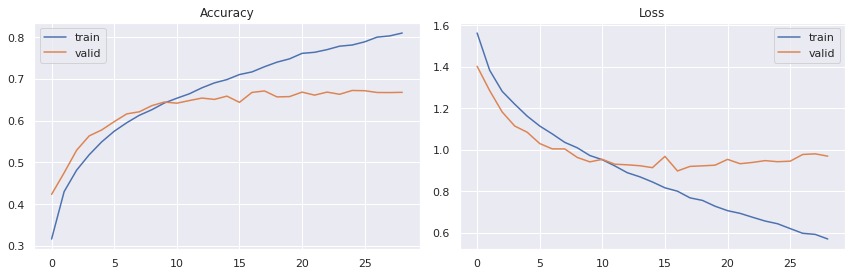

In [120]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129395 missing from current font.
  font.set_text(s, 0, flags=flags)


total wrong validation predictions: 1846


              precision    recall  f1-score   support

           0       0.58      0.61      0.60       825
           1       0.55      0.63      0.58       930
           2       0.72      0.66      0.69      1369
           3       0.85      0.79      0.82      1349
           4       0.51      0.53      0.52       911

    accuracy                           0.66      5384
   macro avg       0.64      0.64      0.64      5384
weighted avg       0.67      0.66      0.66      5384



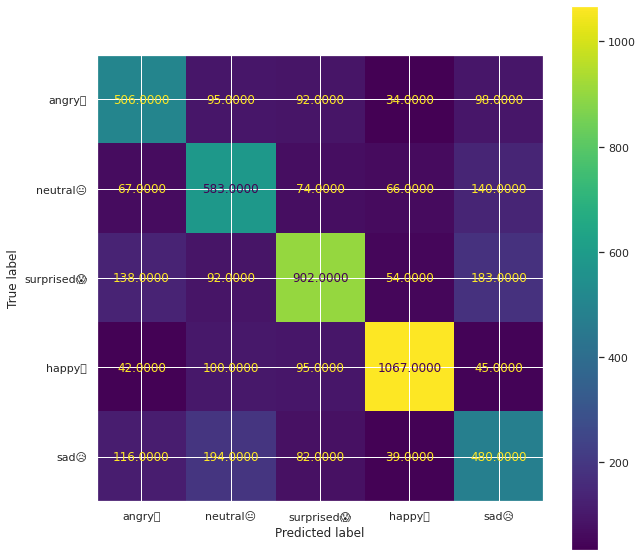

In [125]:
from sklearn.metrics import classification_report

yhat_valid = np.argmax(model.predict(X_test_lstm), axis=-1)

cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, values_format='.4f', ax=ax)
plt.savefig("confusion_matrix_lstm.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

###4) Transfer learning

####4-1) MobileNet

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [126]:
num_classes = 5

mobile_net = MobileNet(
    input_shape = (48, 48, 1),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

for layer in model.layers[:15]:
    layer.trainable = False

transfer_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

ValueError: ignored

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

####4-2) Resnet50 + VGGFace2

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shae=(48,48,1),include_top=False,weights='imagenet')

In [ ]:
folder = 'logs/ResNet-50'

# Parameters
num_classes         = 5
epochs_top_layers   = 5
epochs_all_layers   = 100
batch_size          = 128

In [ ]:
base_model = VGGFace(
    model       = 'resnet50',
    include_top = False,
    weights     = 'vggface',
    input_shape = (48, 48, 1))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

In [ ]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 10, # 10 degrees
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(
    train_data_x,
    train_data_y,
    batch_size  = batch_size)

Train upper layers

In [ ]:
# First: train only the top layers (which were randomly initialized) freezing all convolutional ResNet-50 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer   = Adam(lr = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
# as well as activation histograms for the different layers in your model
    # log_dir:          The path of the directory where to save the log files to be parsed by TensorBoard
    # histogram_freq:   Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    #                   If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations
    # write_graph:      Whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True
    # write_grads:      Whether to visualize gradient histograms in TensorBoard. histogram_freq must be greater than 0
    # write_images:     Whether to write model weights to visualize as image in TensorBoard
# To visualize the files created during training, run in your terminal: tensorboard --logdir path_to_current_dir/Graph
tensorboard_top_layers = TensorBoard(
	log_dir         = folder + '/logs_top_layers',
	histogram_freq  = 0,
	write_graph     = True,
	write_grads     = False,
	write_images    = True)

model.fit_generator(
    generator           = train_generator,
    steps_per_epoch     = len(train_data_x) // batch_size,  # samples_per_epoch / batch_size
    epochs              = epochs_top_layers,                            
    validation_data     = val_data,
    callbacks           = [tensorboard_top_layers])

In [ ]:

# FULL NETWORK TRAINING ###############################################################################################################################

# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from ResNet-50

# Fine-tuning of all the layers
for layer in model.layers:
    layer.trainable = True

# We need to recompile the model for these modifications to take effect (we use SGD with nesterov momentum and a low learning rate)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       float >= 0. Learning rate
        # momentum: float >= 0. Parameter updates momentum
        # decay:    float >= 0. Learning rate decay over each update
        # nesterov: boolean. Whether to apply Nesterov momentum
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = SGD(lr = 1e-4, momentum = 0.9, decay = 0.0, nesterov = True),
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
tensorboard_all_layers = TensorBoard(
    log_dir         = folder + '/logs_all_layers',
    histogram_freq  = 0,
    write_graph     = True,
    write_grads     = False,
    write_images    = True)

def scheduler(epoch):
    updated_lr = K.get_value(model.optimizer.lr) * 0.5
    if (epoch % 3 == 0) and (epoch != 0):
        K.set_value(model.optimizer.lr, updated_lr)
        print(K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)

# Learning rate scheduler
    # schedule: a function that takes an epoch index as input (integer, indexed from 0) and current learning
    #           rate and returns a new learning rate as output (float)
reduce_lr = LearningRateScheduler(scheduler)


# Reduce learning rate when a metric has stopped improving
	# monitor: 	Quantity to be monitored
	# factor: 	Factor by which the learning rate will be reduced. new_lr = lr * factor
	# patience:	Number of epochs with no improvement after which learning rate will be reduced
	# mode: 	One of {auto, min, max}
	# min_lr:	Lower bound on the learning rate
reduce_lr_plateau = ReduceLROnPlateau(
	monitor 	= 'val_loss',
	factor		= 0.5,
	patience	= 3,
	mode 		= 'auto',
	min_lr		= 1e-8)

# Stop training when a monitored quantity has stopped improving
	# monitor:		Quantity to be monitored
	# patience:		Number of epochs with no improvement after which training will be stopped
	# mode: 		One of {auto, min, max}
early_stop = EarlyStopping(
	monitor 	= 'val_loss',
	patience 	= 10,
	mode 		= 'auto')

class ModelCheckpoint(Callback):

	def __init__(self, filepath, folder, monitor = 'val_loss', verbose = 0, save_best_only = False, save_weights_only = False, mode = 'auto', period = 1):
		super(ModelCheckpoint, self).__init__()
		self.monitor 				= monitor
		self.verbose		 		= verbose
		self.filepath 				= filepath
		self.folder 				= folder
		self.save_best_only 		= save_best_only
		self.save_weights_only		= save_weights_only
		self.period 				= period
		self.epochs_since_last_save	= 0
		
		if mode not in ['auto', 'min', 'max']:
			warnings.warn('ModelCheckpoint mode %s is unknown, ' 'fallback to auto mode.' % (mode), RuntimeWarning)
			mode = 'auto'

		if mode == 'min':
			self.monitor_op = np.less
			self.best = np.Inf
		elif mode == 'max':
			self.monitor_op = np.greater
			self.best = -np.Inf
		else:
			if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
			    self.monitor_op = np.greater
			    self.best = -np.Inf
			else:
			    self.monitor_op = np.less
			    self.best = np.Inf
	
	def on_epoch_end(self, epoch, logs=None):
		logs = logs or {}
		self.epochs_since_last_save += 1
		if self.epochs_since_last_save >= self.period:
			self.epochs_since_last_save = 0
			filepath = self.filepath.format(epoch = epoch + 1, **logs)
			if self.save_best_only:
				current = logs.get(self.monitor)
				if current is None:
				    warnings.warn('Can save best model only with %s available, ' 'skipping.' % (self.monitor), RuntimeWarning)
				else:
					if self.monitor_op(current, self.best):
					    if self.verbose > 0:
					        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,' ' saving model to %s' % (epoch + 1, self.monitor, self.best, current, filepath))
					    self.best = current
					    if self.save_weights_only:
					        self.model.save_weights(filepath, overwrite=True)
					    else:
							self.model.save(filepath, overwrite=True)
							# Save model.h5 on to google storage
							with file_io.FileIO(filepath, mode='r') as input_f:
								with file_io.FileIO(self.folder + '/checkpoints/' + filepath, mode='w+') as output_f:	# w+ : writing and reading
									output_f.write(input_f.read())
					else:
						if self.verbose > 0:
						    print('\nEpoch %05d: %s did not improve' %
						          (epoch + 1, self.monitor))
			else:
				if self.verbose > 0:
				    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
				if self.save_weights_only:
				    self.model.save_weights(filepath, overwrite=True)
				else:
					self.model.save(filepath, overwrite=True)
					# Save model.h5 on to google storage
					with file_io.FileIO(filepath, mode='r') as input_f:
						with file_io.FileIO(self.folder + '/checkpoints/' + filepath, mode='w+') as output_f:	# w+ : writing and reading
							output_f.write(input_f.read())

# Save the model after every epoch
	# filepath:       String, path to save the model file
	# monitor:        Quantity to monitor {val_loss, val_acc}
	# save_best_only: If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
	# mode:           One of {auto, min, max}. If save_best_only = True, the decision to overwrite the current save file is made based on either
	#			      the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should
	#			      be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity
	# period:         Interval (number of epochs) between checkpoints
check_point = ModelCheckpoint(
	filepath		= 'ResNet-50_{epoch:02d}_{val_loss:.2f}.h5',
	folder 			= folder,
	monitor 		= 'val_loss', # Accuracy is not always a good indicator because of its yes or no nature
	save_best_only	= True,
	mode 			= 'auto',
	period			= 1)

# We train our model again (this time fine-tuning all the resnet blocks)
model.fit_generator(
    generator           = train_generator,
    steps_per_epoch     = len(train_data_x) // batch_size,  # samples_per_epoch / batch_size 
    epochs              = epochs_all_layers,                        
    validation_data     = val_data,
    callbacks           = [tensorboard_all_layers, reduce_lr, reduce_lr_plateau, early_stop, check_point])

Save model

In [ ]:
model.save(folder + '/ResNet-50.h5')
# Save model.h5 on to google storage
with file_io.FileIO('ResNet-50.h5', mode='r') as input_f:
    with file_io.FileIO(folder + '/ResNet-50.h5', mode='w+') as output_f:  # w+ : writing and reading
        output_f.write(input_f.read())

####4-3)NSL

####4-4) YOLO

#3. Results

#4. Reference


*   [HUMAN EMOTION RECOGNITION USING MACHINE LEARNING](https://education.dellemc.com/content/dam/dell-emc/documents/en-us/2019KS_Nannapaneni-Human_Emotion_Recognition_using_Machine_Learning.pdf)  (2019)
*   [A Joint Convolutional Bidirectional LSTM Framework for Facial
Expression Recognition](https://www.jstage.jst.go.jp/article/transinf/E101.D/4/E101.D_2017EDL8208/_pdf) (2018)
*   [Strengths and Weaknesses of Deep Learning Models
for Face Recognition Against Image Degradations](https://arxiv.org/pdf/1710.01494.pdf) (2017)

